In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve, precision_score, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import timedelta
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
parking_dataset = pd.read_csv('parking_dataset.csv')
parking_dataset.head()

,Timestamp,ParkingSpaceID,OccupancyStatus,VehicleType
0,01-01-2023,80.0,Empty,Motorcycle
1,02-01-2023,85.0,Empty,Car
2,03-01-2023,92.0,Reserved,Motorcycle
3,04-01-2023,72.0,Occupied,Car
4,05-01-2023,29.0,Occupied,Bicycle


In [5]:
missing_values = parking_dataset.isnull().sum()
print("Missing Values:")
print(missing_values)


Missing Values:
Timestamp          0
ParkingSpaceID     0
OccupancyStatus    0
VehicleType        0
dtype: int64


In [6]:
parking_dataset['ParkingSpaceID'].fillna(parking_dataset['ParkingSpaceID'].mean(), inplace=True)
parking_dataset['OccupancyStatus'].fillna(parking_dataset['OccupancyStatus'].mode()[0], inplace=True)
parking_dataset['VehicleType'].fillna(parking_dataset['VehicleType'].mode()[0], inplace=True)


In [7]:
parking_dataset['Timestamp'] = pd.to_datetime(parking_dataset['Timestamp'], format='%d-%m-%Y')
parking_dataset['Date'] = parking_dataset['Timestamp'].dt.date
parking_dataset['Time'] = parking_dataset['Timestamp'].dt.time
parking_dataset['DayOfWeek'] = parking_dataset['Timestamp'].dt.day_name()

print("OccupancyStatus Distribution:")
print(parking_dataset['OccupancyStatus'].value_counts())

OccupancyStatus Distribution:
OccupancyStatus
Occupied    134
Empty       122
Reserved    109
Name: count, dtype: int64


In [8]:
label_encoder = LabelEncoder()
parking_dataset['OccupancyStatus'] = label_encoder.fit_transform(parking_dataset['OccupancyStatus'])
parking_dataset['VehicleType'] = label_encoder.fit_transform(parking_dataset['VehicleType'])


In [9]:
X = parking_dataset[['ParkingSpaceID', 'VehicleType']]
y = parking_dataset['OccupancyStatus']



In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train_scaled, y_train)
logistic_preds = logistic_model.predict(X_test_scaled)


In [13]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_preds = rf_model.predict(X_test_scaled)


In [14]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_preds = svm_model.predict(X_test_scaled)


In [15]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)  
sarima_model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
results = sarima_model.fit(disp=False)

In [16]:
sarima_preds = results.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, dynamic=False)
mse = mean_squared_error(y_test, sarima_preds)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.6128279289203608


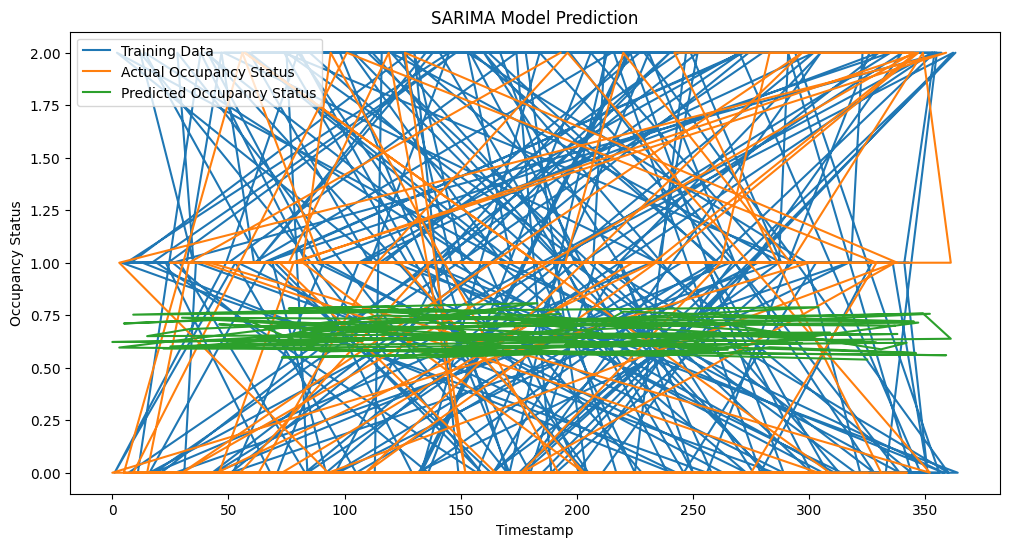

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_test.index, y_test, label='Actual Occupancy Status')
plt.plot(y_test.index, sarima_preds, label='Predicted Occupancy Status')
plt.title('SARIMA Model Prediction')
plt.xlabel('Timestamp')
plt.ylabel('Occupancy Status')
plt.legend()
plt.show()


Model: Logistic Regression
Precision: 0.2288
Accuracy: 0.3562
Mean Absolute Error (MAE): 0.7534
Mean Squared Error (MSE): 0.9726
Root Mean Squared Error (RMSE): 0.9862

Model: Random Forest
Precision: 0.3832
Accuracy: 0.3425
Mean Absolute Error (MAE): 0.8767
Mean Squared Error (MSE): 1.3151
Root Mean Squared Error (RMSE): 1.1468

Model: SVM
Precision: 0.5790
Accuracy: 0.3699
Mean Absolute Error (MAE): 0.7260
Mean Squared Error (MSE): 0.9178
Root Mean Squared Error (RMSE): 0.9580

Model: SARIMA
Mean Squared Error (MSE): 0.6128


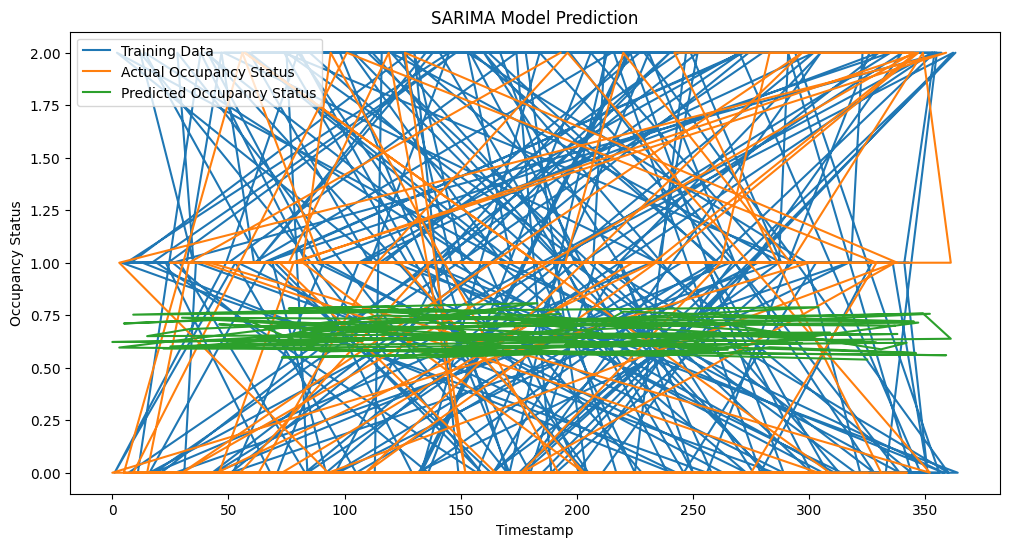

In [20]:
models = [logistic_model, rf_model, svm_model, sarima_model]
model_names = ['Logistic Regression', 'Random Forest', 'SVM', 'SARIMA']

for i, model in enumerate(models):
    if 'SARIMAX' not in str(type(model)):
        # For non-time series models
        y_pred = model.predict(X_test_scaled)
        
        # Metrics for non-time series models
        precision = precision_score(y_test, y_pred, average='weighted') if len(set(y_test)) > 2 else precision_score(y_test, y_pred, average='binary')
        accuracy = accuracy_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        
        print(f'\nModel: {model_names[i]}')
        print(f'Precision: {precision:.4f}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Mean Absolute Error (MAE): {mae:.4f}')
        print(f'Mean Squared Error (MSE): {mse:.4f}')
        print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

    else:
        # For SARIMA model
        start = len(X_train)
        end = len(X_train) + len(X_test) - 1
        y_pred = results.predict(start=start, end=end, dynamic=False)

        # Metrics for time series models
        mse = mean_squared_error(y_test, y_pred)
        print(f'\nModel: {model_names[i]}')
        print(f'Mean Squared Error (MSE): {mse:.4f}')

        # Plot the results
        plt.figure(figsize=(12, 6))
        plt.plot(y_train.index, y_train, label='Training Data')
        plt.plot(y_test.index, y_test, label='Actual Occupancy Status')
        plt.plot(y_test.index, y_pred, label='Predicted Occupancy Status')
        plt.title(f'{model_names[i]} Model Prediction')
        plt.xlabel('Timestamp')
        plt.ylabel('Occupancy Status')
        plt.legend()
        plt.show()
